<a href="https://colab.research.google.com/github/jakey1610/MachineLearningL3/blob/master/birdgen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q torch torchvision livelossplot

**Main imports**

In [0]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [11]:
#https://gist.github.com/Miladiouss/6ba0876f0e2b65d0178be7274f61ad2f
# Transformations
RC   = transforms.RandomCrop(32, padding=4)
RHF  = transforms.RandomHorizontalFlip()
RVF  = transforms.RandomVerticalFlip()
NRM  = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT   = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug   = transforms.Compose([TT, NRM])

# Downloading/Louding CIFAR10 data
trainset  = CIFAR10(root='./data', train=True , download=True, transform = transform_with_aug)
testset   = CIFAR10(root='./data', train=False, download=True, transform = transform_no_aug)
classDict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

# Separating trainset/testset data/label
x_train  = trainset.data
x_test   = testset.data
y_train  = trainset.targets
y_test   = testset.targets

# Define a function to separate CIFAR classes by class index

def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:,0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]
    
    return x_i

class DatasetMaker(Dataset):
    def __init__(self, datasets, transformFunc = transform_no_aug):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths  = [len(d) for d in self.datasets]
        self.transformFunc = transformFunc
    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        img = self.transformFunc(img)
        return img, class_label

    def __len__(self):
        return sum(self.lengths)
    
    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index  = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class

Files already downloaded and verified
Files already downloaded and verified


In [12]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

bird_trainset = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['bird'])],
        transform_with_aug
    )
bird_testset  = \
    DatasetMaker(
        [get_class_i(x_test , y_test , classDict['bird'])],
        transform_no_aug
    )

# kwargs = {'num_workers': 2, 'pin_memory': False}

# Create datasetLoaders from trainset and testset
train_loader   = DataLoader(bird_trainset, batch_size=16, shuffle=True)
test_loader    = DataLoader(bird_testset , batch_size=16, shuffle=False)


train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

> Size of training dataset 5000
> Size of test dataset 1000


**View some of the test dataset**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

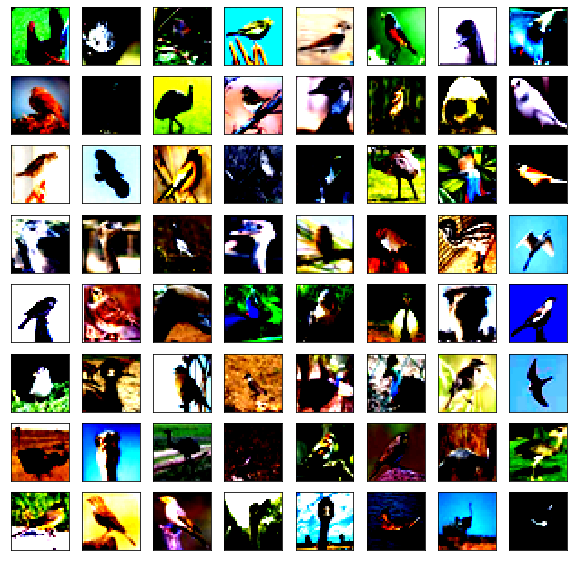

In [13]:
plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_loader.dataset[i][0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    # plt.xlabel(class_names[test_loader.dataset[i][1]])

**Define the Generator and Discriminator Networks**

In [0]:
class Generator(nn.Module):
    def __init__(self, f=64):
        super(Generator, self).__init__()
        self.generate = nn.Sequential(
            nn.ConvTranspose2d(100, f*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(f*8, f*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(f*4, f*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(f*2, f, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f),
            nn.ReLU(True),
            nn.ConvTranspose2d(f, 3, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )
class Discriminator(nn.Module):
    def __init__(self, f=64):
        super(Discriminator, self).__init__()
        self.discriminate = nn.Sequential(
            torch.nn.utils.spectral_norm(nn.Conv2d(3, f, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.utils.spectral_norm(nn.Conv2d(f, f*2, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.utils.spectral_norm(nn.Conv2d(f*2, f*4, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.utils.spectral_norm(nn.Conv2d(f*4, f*8, 3, 1, 1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.utils.spectral_norm(nn.Conv2d(f*8, 3, 3, 1, 1)),
            nn.Sigmoid()
        )
        

**Initialise the Optimisers**

In [0]:
GN = Generator().to(device)
DN = Discriminator().to(device)
# initialise the optimisers
optimiser_G = torch.optim.Adam(GN.parameters(), lr=0.001)
optimiser_D = torch.optim.Adam(DN.parameters(), lr=0.001)
bce_loss = nn.BCELoss()
epoch = 0
liveplot = PlotLosses()

**Discriminator Training Loop**

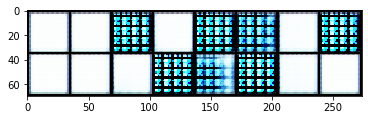

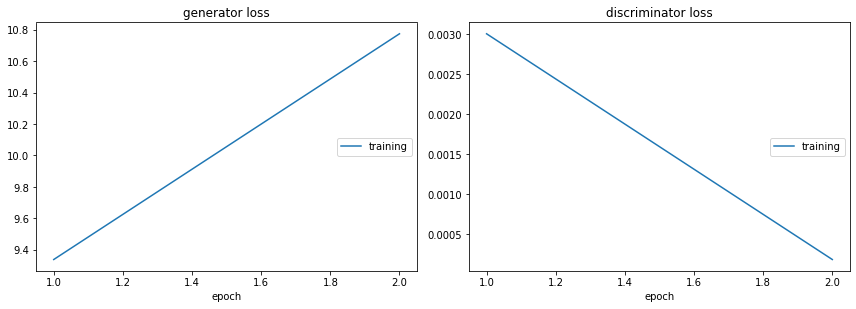

generator loss:
training   (min:    9.338, max:   10.774, cur:   10.774)

discriminator loss:
training   (min:    0.000, max:    0.003, cur:    0.000)


In [0]:
# training loop
while (epoch<50):
    
    # arrays for metrics
    gen_loss_arr = np.zeros(0)
    dis_loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(500):
        # train discriminator 
        for j in range(5):
            x,t = next(train_iterator)
            x,t = x.to(device), t.to(device)
            optimiser_D.zero_grad()
            g = GN.generate(torch.randn(x.size(0), 100, 1, 1).to(device))
            l_r = bce_loss(DN.discriminate(x).mean(), torch.ones(1)[0].to(device)) # real -> 1
            l_f = bce_loss(DN.discriminate(g.detach()).mean(), torch.zeros(1)[0].to(device)) #  fake -> 0
            loss_d = (l_r + l_f)/2.0
            loss_d.backward()
            optimiser_D.step()
          
        # train generator
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)
        optimiser_G.zero_grad()
        g = GN.generate(torch.randn(x.size(0), 100, 1, 1).to(device))
        loss_g = bce_loss(DN.discriminate(g).mean(), torch.ones(1)[0].to(device)) # fake -> 1
        loss_g.backward()
        optimiser_G.step()

        gen_loss_arr = np.append(gen_loss_arr, loss_g.item())
        dis_loss_arr = np.append(dis_loss_arr, loss_d.item())

    # plot some examples
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

    liveplot.update({
        'generator loss': gen_loss_arr.mean(),
        'discriminator loss': dis_loss_arr.mean()
    })
    liveplot.draw()
    epoch = epoch+1

**Save the trained model**

In [0]:
#Save the trained model
PATH_DN = './DN_cifar_net.pth'
torch.save(DN.state_dict(), PATH_DN)
PATH_GN = './GN_cifar_net.pth'
torch.save(GN.state_dict(), PATH_GN)